<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/riceyieldcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# イネ収量予測モデル

<img src= "https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/4e5eefd594adebc4442e7d9268bde2aee519eed9544f5d0d2cd9b68dbdbbabf9.png" width = 50%>

岡山大学プレスリリース（https://www.okayama-u.ac.jp/up_load_files/press_r5/press20230721-1.pdf ）より引用

## ライセンス
- 公式レポジトリ（https://github.com/r1wtn/rice_yield_CNN ）
    - Apache-2.0
- Tanaka et al., Plant Phenomics, 2023 (https://spj.science.org/doi/10.34133/plantphenomics.0073)
    - 調査中

## 解説

ニューラルネットワークに画像を供試した際の出力は[0,0,....1.,0,...0]のようなone-hotラベルである必要はありません。例えば、出力を数字にすれば回帰モデルとして使うことができます。

岡山大学の田中らは、イネの収量調査を迅速に行うため、
画像を入力としてイネの収量を出力するようなモデルをつくりました。
詳しくはPlant Phenomics誌に掲載された論文を参照してください。

特筆すべきはモデルのコンパクトさです。モデルの構造を見てましょう。

<img width=50% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/db6c68c70b4b3a612118ebd0adc5120f29063695932fdc0d7854923baa20ecab.png">

今回のモデル（左）をNetron（https://netron.app/） を利用してネットワーク構造を可視化します。比較のために、よく使用されるResNet50やエッジモデル用のMobileNetV3(small)もあわせて並べます。上からデータを流し込み、１つ１つのブロックでconvolution, relu, pooling, batchnormなどの処理が行われて下に流れていき、下方より出力データを得る、というイメージです。

ひと目見て明らかなように、ネットワークの層が他２つと比べてとても少ないのが特徴的です。これはファイルサイズにも反映されています。

<img width=25% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/ec3a6eac7a5fcea3e3ff079d602ac72718bcbaf8deefd70d6e732439aa5612af.png">

驚くべきことに224Kbしかありません。ResNet50やMobileNetV3(small)とは桁が違います。

どうやって、このようなネットワークを定義したのでしょうか？彼らはNeural Network Consoleと呼ばれるSonyのソフトを使い、最適なモデルの探索を行ったと記述しています。見出したモデルをpytorchに持ち込み、パイプラインを構築しています。

>The structure of the CNN was developed by Neural Network Console software version 1.5 (Sony Network Communications Inc., Japan, https://dl.sony.com/) Tanaka et al., 2023, Plant Phenomics

## 実行コード

今回はスマートフォンではなく、Colaboratoryで収量予測を行います。

モデルがとても軽量ですのでColaboratoryの実行環境はGPUでなく、CPUで問題ありません

In [1]:
!git clone https://github.com/r1wtn/rice_yield_CNN.git

Cloning into 'rice_yield_CNN'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 10), reused 33 (delta 6), pack-reused 0
Receiving objects: 100% (40/40), 1.57 MiB | 20.16 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [15]:
!pip install gdown
# for data persistence, model shall be uploaded to github or zenodo.
!gdown 1XgTUGK8130gnY9AF3gYv9zhJSJaxhHVp

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=54a6a39382e33ad6e9637236417d227669d89b47499cf854230a1ac7e62c2ca5
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


## 推論

In [16]:
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from rice_yield_CNN.lib.model import RiceYieldCNN

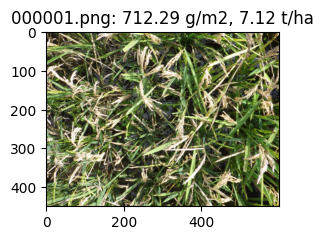

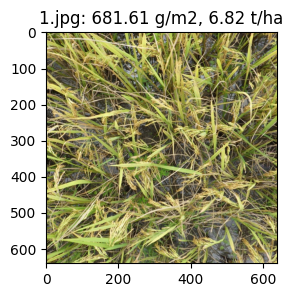

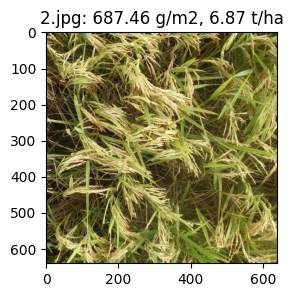

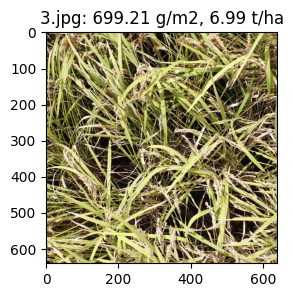

In [25]:
def preprocess(image, input_resolution, mean, std, device):
    image = cv2.resize(image, input_resolution)
    input_img = image.astype(np.float32) / 255.0
    input_img = (input_img - np.array(mean).astype(np.float32)) / \
        np.array(std).astype(np.float32)
    input_img = input_img.transpose(2, 0, 1)
    input_img = torch.Tensor(input_img).unsqueeze(0).to(device)
    return input_img


INPUT_SIZE = (512, 512)
MEAN = 0.5
STD = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = "/content/base_nnc6_57.pth"

model = RiceYieldCNN()
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device(device))
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict, strict=True)
model.to(device)
model.eval()


image_dir = "/content/rice_yield_CNN/example"
image_files = sorted(os.listdir(image_dir))

for image_file in image_files:
    path = os.path.join(image_dir, image_file)
    image = cv2.imread(path)
    input_tensor = preprocess(image, INPUT_SIZE, MEAN, STD, device)
    preds = model(input_tensor)
    pred_yield = preds[0]
    pred_yield = round(float(pred_yield.squeeze(0).detach().cpu().numpy()), 2)
    s = "{}: {} g/m2, {:.2f} t/ha".format(image_file, pred_yield, pred_yield/100)
    plt.figure(figsize=(3,3))
    plt.title(s)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()


## 最後に

”使えればよい”という前提で深層学習のフレームワークが提供しているモデル（ReNet系、MobileNet系、VGG系など）と付随する訓練済み重みをファインチューンして使用する研究事例をとても多く見かけます。

実際、それなりの精度が出て、なおかつ、負荷の高い計算を実行できる計算資源を随時用意できるのであれば、画像解析パイプラインの構築の手間が省けるので合理的です。

一方では、解析したい画像の対象によっては、そのようなモデルはオーバースペックであることもありますし、能力が限定的なエッジデバイスでの利用は現実的ではありません。

筆者らはスマートフォンで開発したモデルを使用することを意図しており（下図）、そのような場合においては上で言及したようなソフトでモデル設計をしたり、Neural Architecture Searchなと呼ばれる手法を用いてモデル設計することも有効です。

<img width=25% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/851d182c009fb3638ea7ca43879fc3f26fced00db9c3902d562903e5eda078df.png"> 

スマホアプリをインストールすることで、イネの収量予測をiPhone/Androidで行うことができます（https://r1-technologies.com/products ）。